In [1]:
import os
import sys
import random
import numpy as np
import cv2
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
import tensorflow.keras.backend as K
from tensorflow.keras import layers, models, Sequential, backend
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout, BatchNormalization, Activation, GlobalAveragePooling2D
from tensorflow.keras.layers import Concatenate, Lambda, Input, ZeroPadding2D, AveragePooling2D, DepthwiseConv2D, Reshape

In [2]:

class DataGen(keras.utils.Sequence):  
    def __init__(self, ids, path, batch_size=10, image_size=128):
        self.ids = ids
        self.path = path
        self.batch_size = batch_size#tamanho da sample do treinamento
        self.image_size = image_size#tamanho da img
        self.on_epoch_end()
        
    def __load__(self, id_name):
        
        image_path = os.path.join(self.path, "image", id_name) + ".jpeg"
        mask_path = os.path.join(self.path, "segmentation", id_name) + "_expert.png"
        
        
        image = cv2.imread(image_path,1)#carregar
        image = cv2.resize(image, (self.image_size, self.image_size))#ajustar tamanho
        mask = np.zeros((self.image_size, self.image_size, 1))#128*128*1
        _mask = cv2.imread(mask_path, -1)#cv2.IMREAD_UNCHANGED
        _mask = cv2.resize(_mask, (self.image_size, self.image_size))#ajustar tamanho
        _mask = np.expand_dims(_mask, axis=-1)
        mask = np.maximum(mask, _mask)
        
        #normalizar
        image = image/255.0
        mask = mask/255.0
        
        return image, mask
    
    def __getitem__(self, index):
        if(index+1)*self.batch_size > len(self.ids):
            self.batch_size = len(self.ids) - index*self.batch_size
        
        files_batch = self.ids[index*self.batch_size : (index+1)*self.batch_size]
        
        image = []
        mask  = []
        
        for id_name in files_batch:
            _img, _mask = self.__load__(id_name)
            image.append(_img)
            mask.append(_mask)
            
        image = np.array(image)
        mask  = np.array(mask)
        
        return image, mask   #array
    
    def on_epoch_end(self):
        pass
    
    def __len__(self):
        return int(np.ceil(len(self.ids)/float(self.batch_size)))

In [3]:
image_size = 128
path = "/content/drive/My Drive/isic/"
train_path = "/content/drive/My Drive/isic/image"
batch_size = 10   

train_ids = []
for files in os.walk(train_path):
   for name in files:
      train_ids.append(name)

train_ids = train_ids[2]#nome do arquivo
train_ids = [i.split('.', 1)[0] for i in train_ids]#-extensao .jpg

val_data_size = 40#tamanho dataset validação

valid_ids = train_ids[:val_data_size]
train_ids = train_ids[val_data_size:]#dividido em 2

In [4]:
gen = DataGen(train_ids, path, batch_size=batch_size, image_size=image_size)#le o treinamento

x, y = gen.__getitem__(0)
print(x.shape, y.shape)

(10, 128, 128, 3) (10, 128, 128, 1)


8


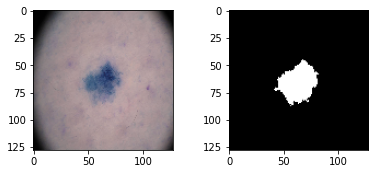

In [5]:

r = random.randint(0, len(x)-1)
print(r)
fig = plt.figure()
fig.subplots_adjust(hspace=0.4, wspace=0.4)
ax = fig.add_subplot(1, 2, 1)
ax.imshow(x[r])
ax = fig.add_subplot(1, 2, 2)
ax.imshow(np.reshape(y[r], (image_size, image_size)), cmap="gray")

In [6]:
#contracao e expansao da Unet
def down_block(x, filters, kernel_size=(3, 3), padding="same", strides=1):
    c = keras.layers.Conv2D(filters, kernel_size, padding=padding, strides=strides, activation="relu")(x)
    c = keras.layers.Conv2D(filters, kernel_size, padding=padding, strides=strides, activation="relu")(c)
    p = keras.layers.MaxPool2D((2, 2), (2, 2))(c)
    return c, p

def up_block(x, skip, filters, kernel_size=(3, 3), padding="same", strides=1):
    us = keras.layers.UpSampling2D((2, 2))(x)
    concat = keras.layers.Concatenate()([us, skip])
    c = keras.layers.Conv2D(filters, kernel_size, padding=padding, strides=strides, activation="relu")(concat)
    c = keras.layers.Conv2D(filters, kernel_size, padding=padding, strides=strides, activation="relu")(c)
    return c

def bottleneck(x, filters, kernel_size=(3, 3), padding="same", strides=1):
    c = keras.layers.Conv2D(filters, kernel_size, padding=padding, strides=strides, activation="relu")(x)
    c = keras.layers.Conv2D(filters, kernel_size, padding=padding, strides=strides, activation="relu")(c)
    return c

In [7]:
def UNet():
    f = [16, 32, 64, 128, 256]
    inputs = keras.layers.Input((image_size, image_size, 3))
    
    p0 = inputs
    c1, p1 = down_block(p0, f[0]) 
    c2, p2 = down_block(p1, f[1]) 
    c3, p3 = down_block(p2, f[2])
    c4, p4 = down_block(p3, f[3]) 
    
    bn = bottleneck(p4, f[4])
    
    u1 = up_block(bn, c4, f[3]) #8 -> 16
    u2 = up_block(u1, c3, f[2]) #16 -> 32
    u3 = up_block(u2, c2, f[1]) #32 -> 64
    u4 = up_block(u3, c1, f[0]) #64 -> 128
    
    outputs = keras.layers.Conv2D(1, (1, 1), padding="same", activation="sigmoid")(u4)
    model = keras.models.Model(inputs, outputs)
    return model

In [ ]:
model = UNet()
model.compile(optimizer="adam", loss="binary_crossentropy", metrics=["acc"])
model.summary()
#tf.keras.utils.plot_model(model, show_shapes=True)

In [9]:
train_gen = DataGen(train_ids, path)
valid_gen = DataGen(valid_ids, path,3,128)

train_steps = len(train_ids)//batch_size
valid_steps = len(valid_ids)//batch_size


history = model.fit(train_gen, validation_data=valid_gen, steps_per_epoch=train_steps, validation_steps=valid_steps, epochs = 20)
model.save("U-Net_Model.h5")

Epoch 1/20
6/6 [==============================] - 89s 15s/step - loss: 0.6892 - acc: 0.5741 - val_loss: 0.6709 - val_acc: 0.7715
Epoch 2/20
6/6 [==============================] - 9s 2s/step - loss: 0.6558 - acc: 0.6908 - val_loss: 0.5158 - val_acc: 0.7715
Epoch 3/20
6/6 [==============================] - 9s 2s/step - loss: 0.6646 - acc: 0.6909 - val_loss: 0.5623 - val_acc: 0.7716
Epoch 4/20
6/6 [==============================] - 10s 2s/step - loss: 0.6022 - acc: 0.6909 - val_loss: 0.4807 - val_acc: 0.7716
Epoch 5/20
6/6 [==============================] - 9s 2s/step - loss: 0.5725 - acc: 0.6909 - val_loss: 0.3904 - val_acc: 0.7716
Epoch 6/20
6/6 [==============================] - 9s 2s/step - loss: 0.5348 - acc: 0.6909 - val_loss: 0.4524 - val_acc: 0.7716
Epoch 7/20
6/6 [==============================] - 9s 2s/step - loss: 0.5451 - acc: 0.6909 - val_loss: 0.3876 - val_acc: 0.7716
Epoch 8/20
6/6 [==============================] - 10s 2s/step - loss: 0.4920 - acc: 0.6926 - val_loss: 0.484

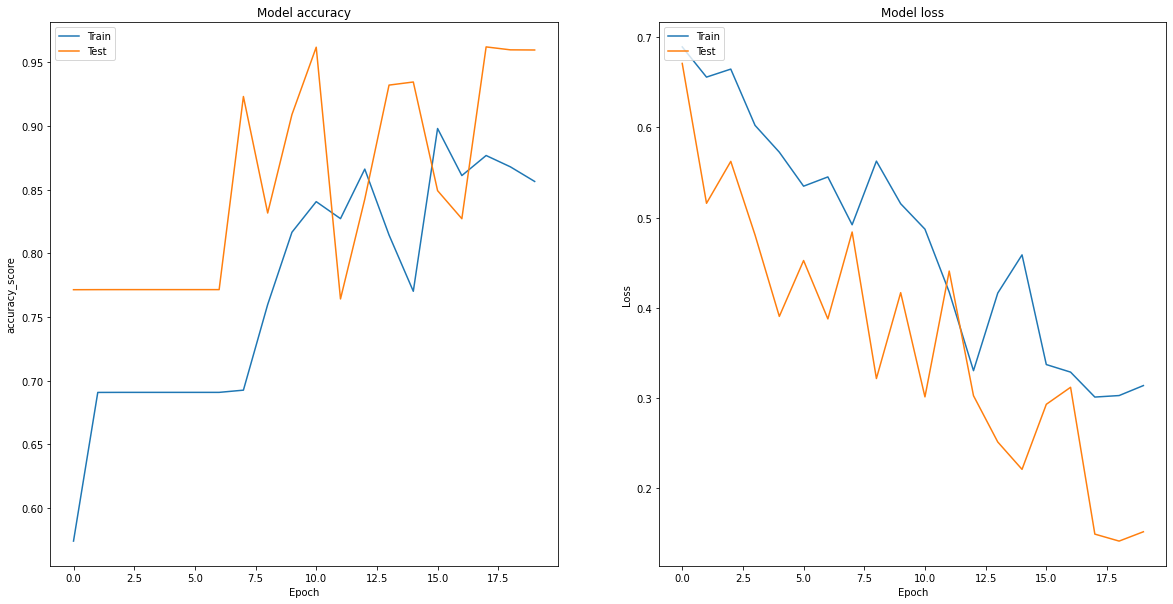

In [31]:
#Plot training & validation iou_score values
plt.figure(figsize=(20, 10))
plt.subplot(121)
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('Model accuracy')
plt.ylabel('accuracy_score')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')

# Plot training & validation loss values
plt.subplot(122)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

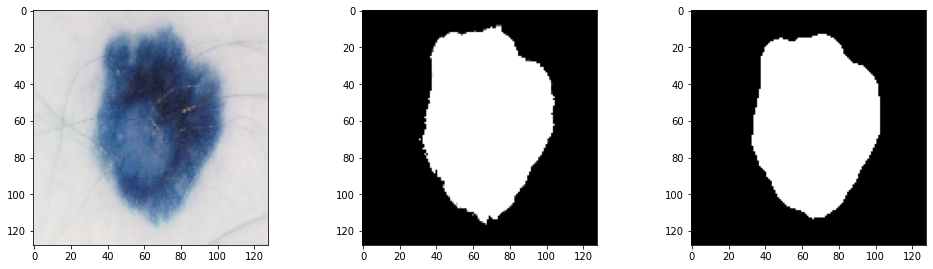

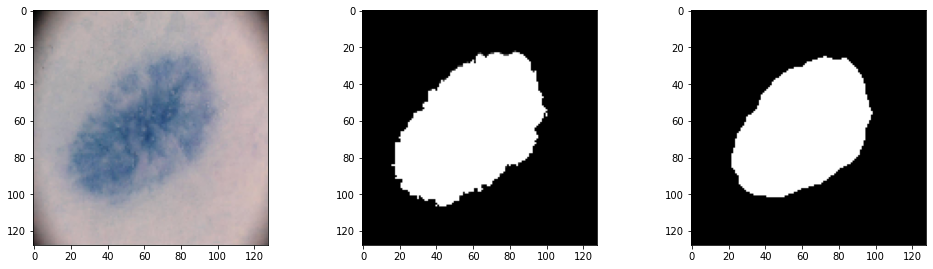

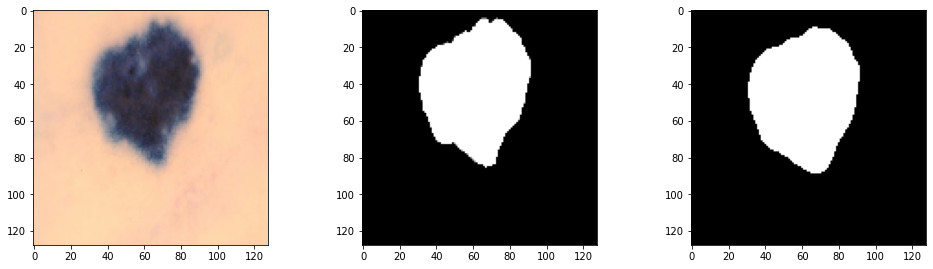

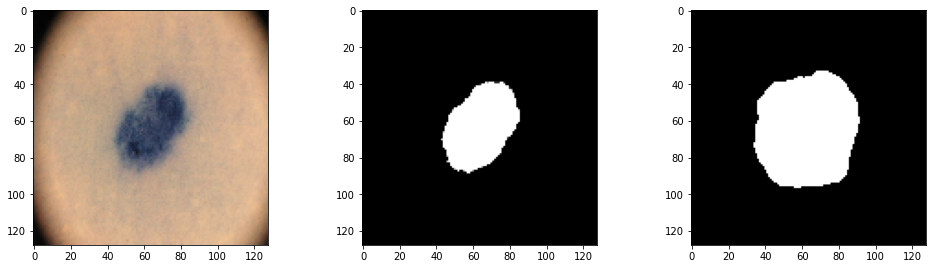

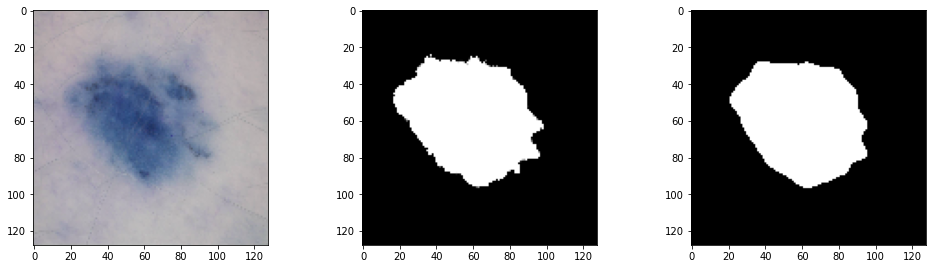

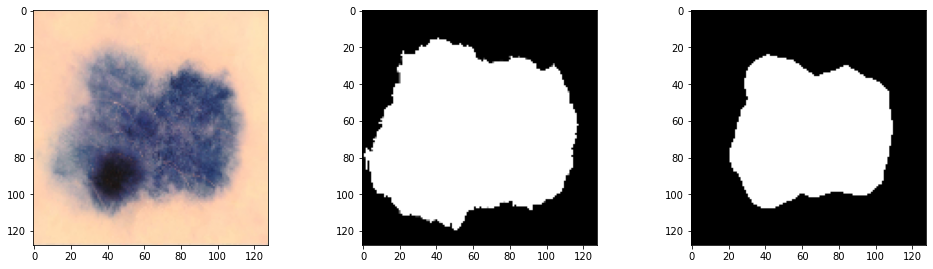

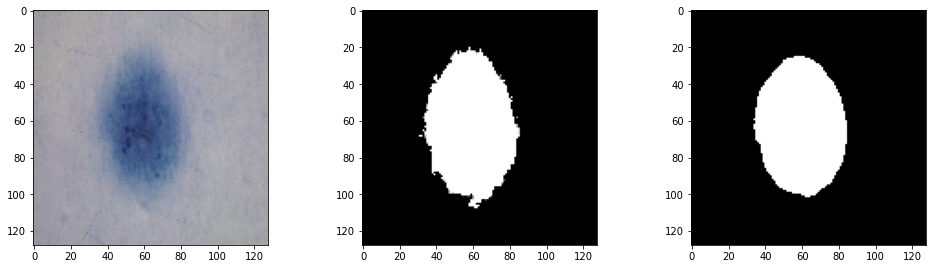

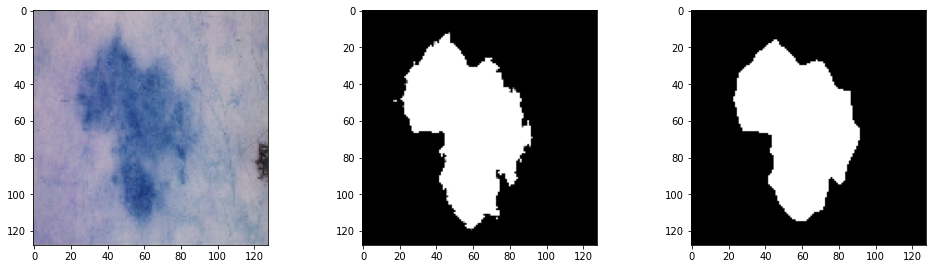

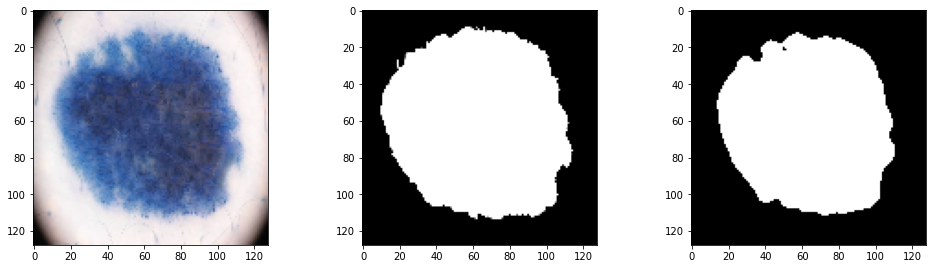

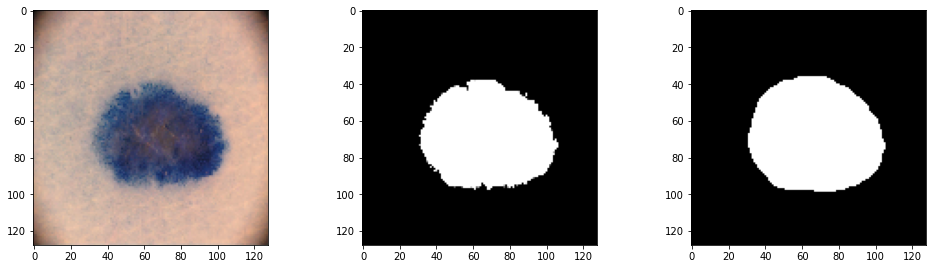

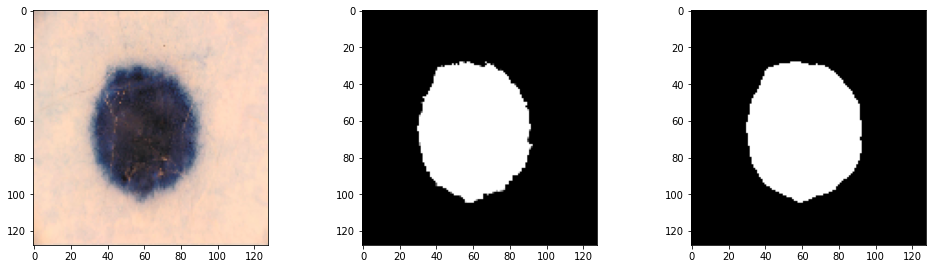

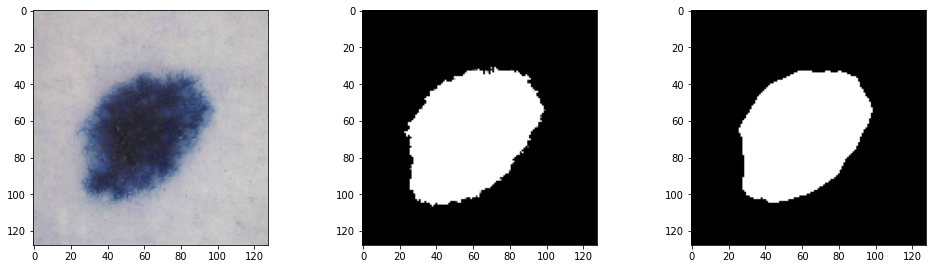

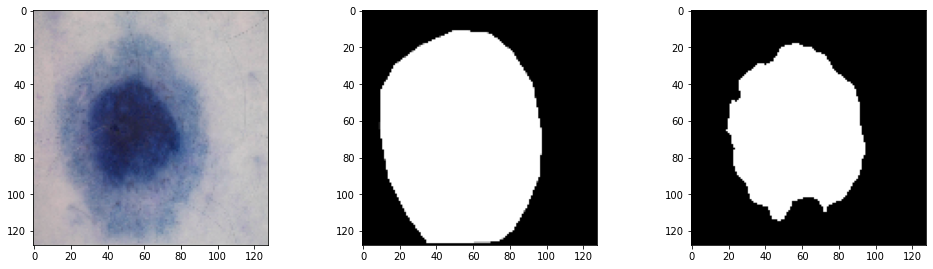

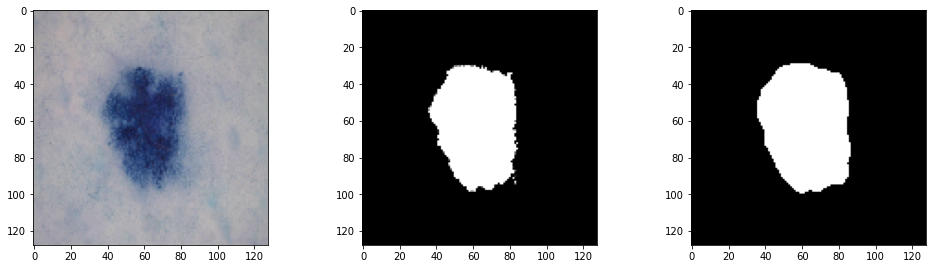

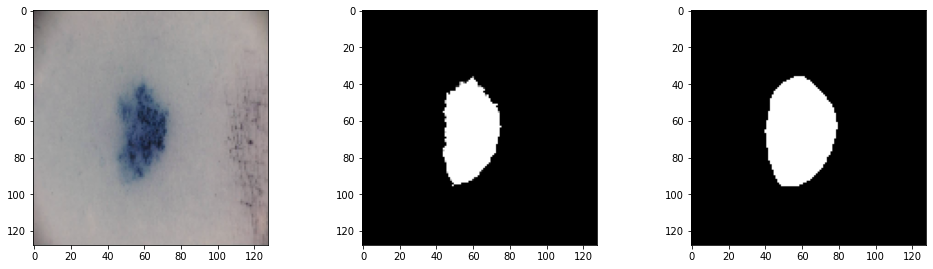

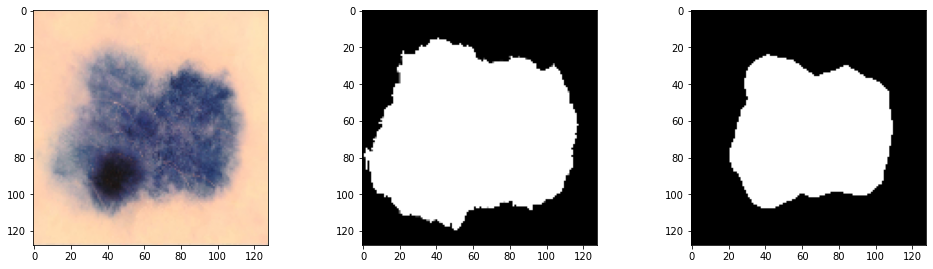

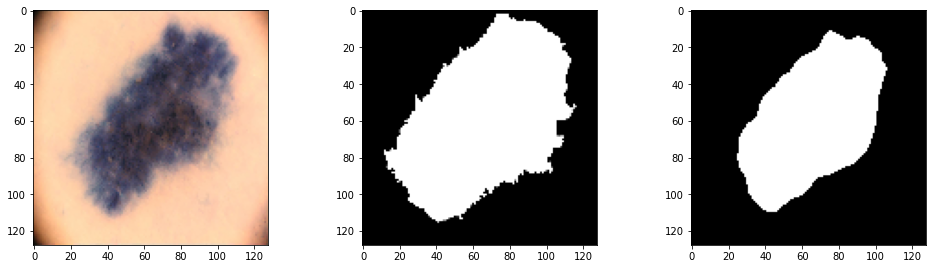

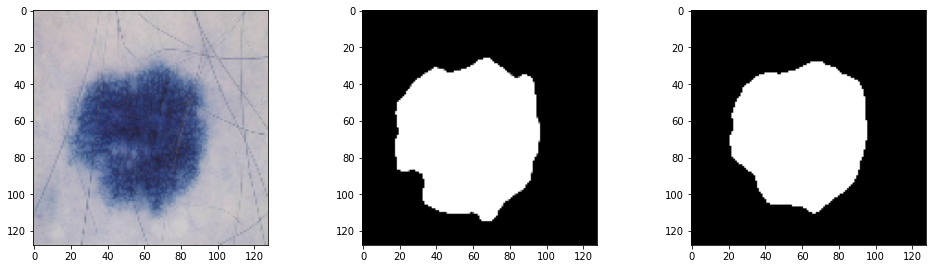

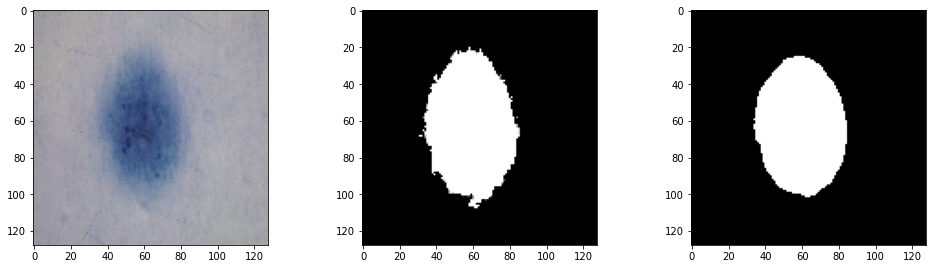

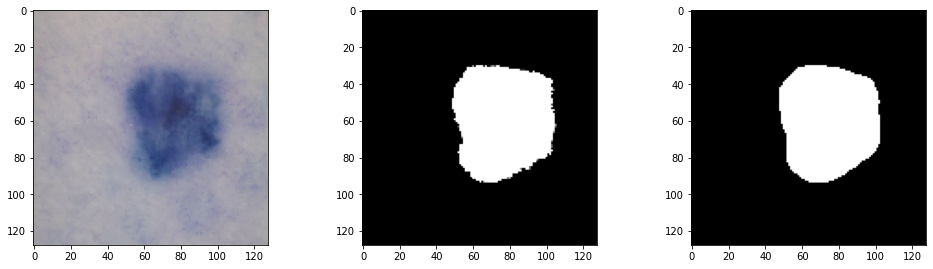

In [17]:
for i in range(0,20):
    x, y = valid_gen.__getitem__(i)
    result = model.predict(x)
    
    result = result > 0.5
    fig = plt.figure(figsize = (16,8))
    fig.subplots_adjust(hspace=0.4, wspace=0.4)
    
    ax = fig.add_subplot(1, 3, 1)
    ax.imshow(x[0])
    ax = fig.add_subplot(1, 3, 2)
    ax.imshow(np.reshape(y[0]*255, (image_size, image_size)), cmap="gray")

    ax = fig.add_subplot(1, 3, 3)
    ax.imshow(np.reshape(result[0]*255, (image_size, image_size)), cmap="gray")

In [18]:
import numpy as np

intersection = np.logical_and(result, y)
union = np.logical_or(result, y)
iou_score = np.sum(intersection) / np.sum(union)
print("IoU is %s" % iou_score)

IoU is 0.9203980099502488


In [22]:
import numpy as np
from sklearn.metrics import confusion_matrix, precision_recall_fscore_support
from sklearn.utils import compute_class_weight as sk_compute_class_weight


def jaccard(y_true, y_pred):
    intersect = np.sum(y_true * y_pred) # Intersection points
    union = np.sum(y_true) + np.sum(y_pred)  # Union points
    return (float(intersect))/(union - intersect +  1e-7)


def compute_jaccard(y_true, y_pred):

    mean_jaccard = 0.
    thresholded_jaccard = 0.

    for im_index in range(y_pred.shape[0]):

        current_jaccard = jaccard(y_true=y_true[im_index], y_pred=y_pred[im_index])

        mean_jaccard += current_jaccard
        thresholded_jaccard += 0 if current_jaccard < 0.65 else current_jaccard

    mean_jaccard = mean_jaccard/y_pred.shape[0]
    thresholded_jaccard = thresholded_jaccard/y_pred.shape[0]

    return mean_jaccard, thresholded_jaccard

print(compute_jaccard(y, result))

(0.9212643452750352, 0.9212643452750352)


In [ ]:
len(train_gen)

24

In [ ]:
train_steps

1

In [ ]:
train_steps

12